In [1]:
import numpy as np, xarray as xr, matplotlib.pyplot as plt, pandas as pd, s3fs
from utils import *

s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [2]:
tos = get_monthly_bucket_data('tos', thing='Omon', model='NorESM2-LM', experiment='historical')

s3://escience2022/Ada/monthly/tos_Omon_NorESM2-LM_historical_*.nc


In [3]:
areacello = get_areacello('NorESM2-LM').squeeze()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [4]:
tosBS = clip_to_region(tos)
areaBS = clip_to_region(areacello)

In [ ]:
tosBS_first = tosBS.tos.isel(time=slice(-12*30, -1)).mean(dim='time')
tosBS_last = tosBS.tos.isel(time=slice(0, 12*30)).mean(dim='time')
(tosBS_first - tosBS_last).plot()

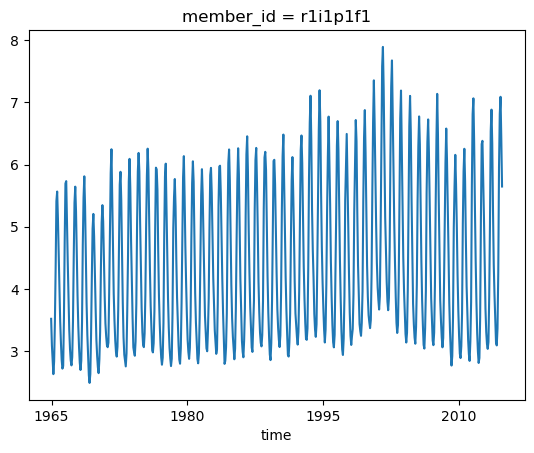

In [7]:
tosBSmean = regional_average(tosBS.tos.isel(time=slice(-12*70, -1)), areaBS.areacello)
tosBSmean.isel(time=slice(-12*50, -1)).plot(x='time')

In [21]:
SI = get_monthly_bucket_data('siconc', thing='SImon', model='NorESM2-LM', experiment='historical', member_id='r1i1p1f1')
SI = clip_to_region(SI.siconc)

s3://escience2022/Ada/monthly/siconc_SImon_NorESM2-LM_historical_r1i1p1f1_*.nc


In [22]:
SImean = regional_average(SI, areacello.areacello)

SIMarch = SI.groupby('time.month')[3]
SIMarchSpatialMean = regional_average(SIMarch, areacello.areacello)
SIMarchTimeMean = SIMarch.mean(dim='time')

SISeptember = SI.groupby('time.month')[9]
SISeptemberSpatialMean = regional_average(SISeptember, areacello.areacello)
SISeptemberTimeMean = SISeptember.mean(dim='time')

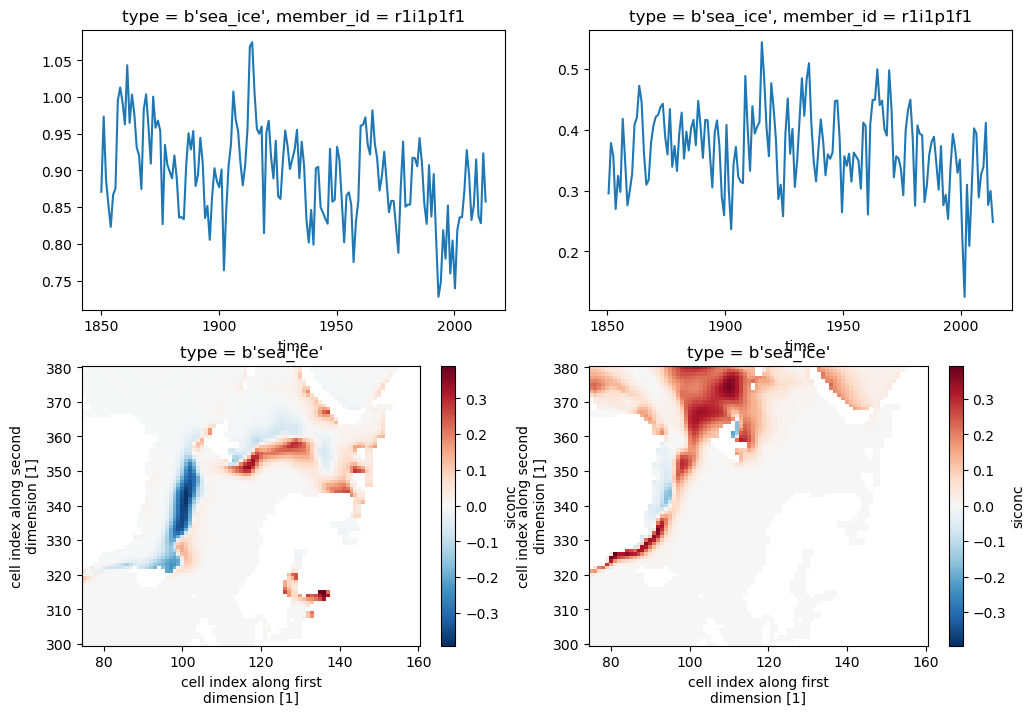

In [26]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(12,8))
SIMarchSpatialMean.isel(time=slice(-12*65, -1)).plot(ax=ax[0,0])
SISeptemberSpatialMean.isel(time=slice(-12*65, -1)).plot(ax=ax[0,1])
(SIMarch.isel(time=slice(-12*30, -1)).mean(dim='time') - SIMarch.isel(time=slice(0, 12*30)).mean(dim='time')).plot(ax=ax[1,0])
(SISeptember.isel(time=slice(-12*30, -1)).mean(dim='time') - SISeptember.isel(time=slice(0, 12*30)).mean(dim='time')).plot(ax=ax[1,1])
plt.show()

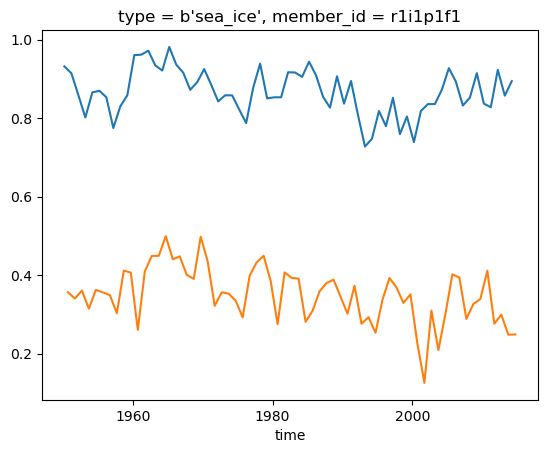

In [16]:
SImeanMarch = SImean.groupby('time.month')[3]
SImeanSeptember = SImean.groupby('time.month')[9]
SImeanMarch.plot()
SImeanSeptember.plot()

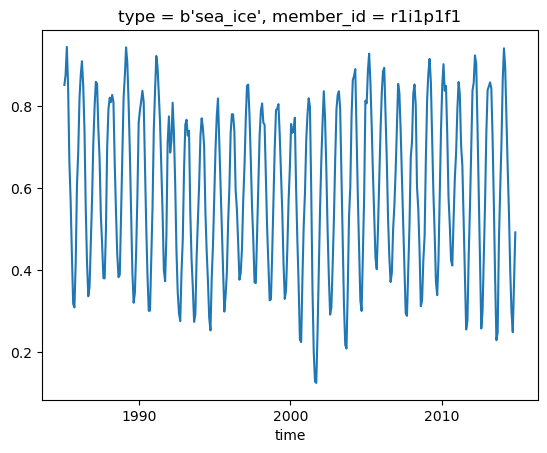

In [35]:
SIBSmean.isel(time=slice(-12*30, -1)).plot(x='time')